In [133]:
%load_ext autoreload
%autoreload 2
import numpy as np
from obspy import UTCDateTime
from matplotlib import pyplot as plt
import ground_motion_qh
from ground_motion_qh.earthquake import EarthquakeCatalog
from ground_motion_qh.get_waveforms import get_stream_multiple_stations, raw_stream_to_amplitude_and_times
import os
from pathlib import Path

base_dir = Path(ground_motion_qh.__file__).parent.parent

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [134]:
download_name = "ANZA_hero_run_1982_M35"

station_metadata = dict(
    stname = ["SND"],
    network = "AZ",
    org = "IRIS",
    latitude = 33.5519,
    longitude = -116.6129,
    start_time = '1982-10-01',
    number_of_tries = 2,
)

earthquake_metadata = {
    "starttime": '1994-01-01',
    "endtime": '2023-01-01',
    "latitude_range": [32,35],
    "longitude_range": [-117.5,-115.5],
    "minimum_magnitude": 3.5, 
}

# explanation of buffers:

# (hypocenter) t1                                                                                            t2
# t0 time shift    pre-buffer     event time window     mid buffer     forecast time window      post buffer
# |------------||--------------||-------------------||--------------||---------- ... ---------||-------------|

analysis_metadata = dict(
    mid_buffer = 10,
    forecast_time_window = 60*60,
    event_time_window = 30,
    shift_times = True,
)

analysis_metadata["pre_buffer"] = 0.05 * analysis_metadata["forecast_time_window"] + analysis_metadata["event_time_window"] + analysis_metadata["mid_buffer"]
analysis_metadata["post_buffer"] = 0.05 * analysis_metadata["forecast_time_window"] + analysis_metadata["event_time_window"] + analysis_metadata["mid_buffer"]


In [135]:
metadata = dict(
    earthquake_metadata = earthquake_metadata,
    analysis_metadata = analysis_metadata,
    station_metadata = station_metadata,
)
# create a data directory with and save the metadata
data_dir = base_dir / "data" / "raw_data" / download_name
os.makedirs(data_dir, exist_ok=True)
np.save(data_dir / "metadata.npy", metadata)

# to load the metadata
#metadata = np.load(data_dir / "metadata.npy", allow_pickle=True)

In [136]:
earthquakes = EarthquakeCatalog(
    filename=data_dir / "local_catalog.csv",
    kwargs=earthquake_metadata,
)

/Users/kdascher/Documents/Documents/USU/Projects/Exploratory_projects/GroundMotion_QH/ground_motion_qh/earthquake.py:196: UserWarning: Reloading /Users/kdascher/Documents/Documents/USU/Projects/Exploratory_projects/GroundMotion_QH/data/raw_data/ANZA_hero_run_1982_M35/local_catalog.csv
  warnings.warn(f"Reloading {filename}")


<Axes: xlabel='Time', ylabel='mag'>

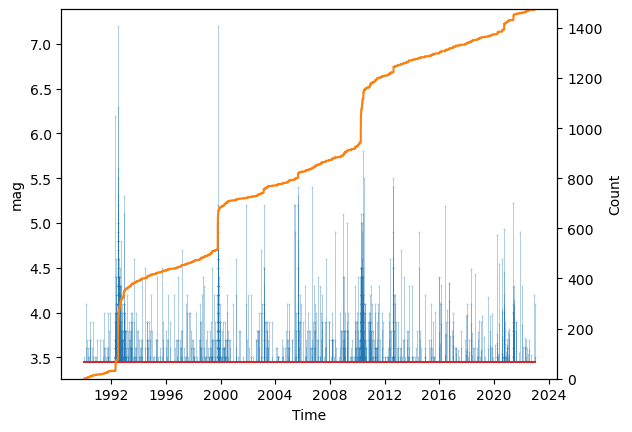

In [137]:
earthquakes.plot_time_series()

<GeoAxes: xlabel='Longitude', ylabel='Latitude'>

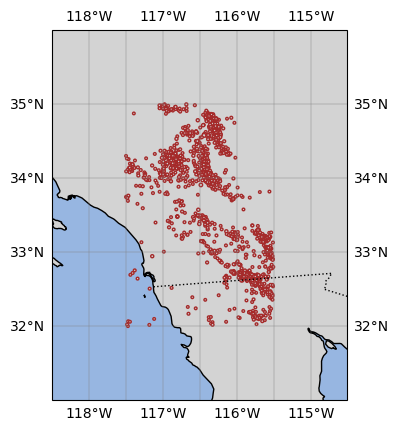

In [138]:
earthquakes.plot_map()

In [139]:
station_x, station_y, _, _ = earthquakes.get_utm_from_lonlat(station_metadata["longitude"], station_metadata["latitude"])
earthquakes_x, earthquakes_y, _, _ = earthquakes.get_utm_from_lonlat(earthquakes.catalog.lon.values, earthquakes.catalog.lat.values) 
distances = np.sqrt((earthquakes_x - station_x)**2 + (earthquakes_y - station_y)**2)

Text(0.5, 0, 'Station-Earhthquake distance (km)')

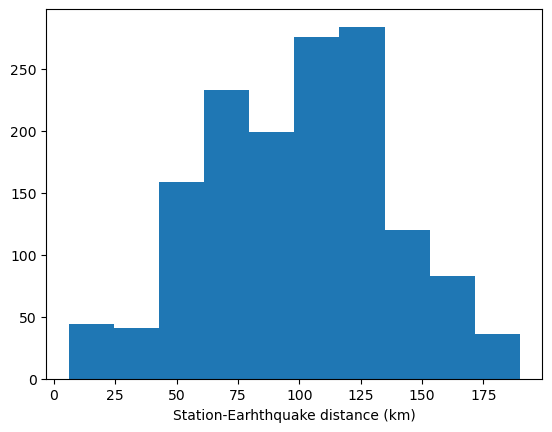

In [140]:
plt.hist(distances/1000)
plt.xlabel("Station-Earhthquake distance (km)")

In [141]:
minus_time_range = [
    analysis_metadata["pre_buffer"],
    analysis_metadata["pre_buffer"] + analysis_metadata["event_time_window"]
]

plus_time_range = [
    analysis_metadata["pre_buffer"] + analysis_metadata["event_time_window"],
    analysis_metadata["pre_buffer"] + analysis_metadata["event_time_window"] + analysis_metadata["mid_buffer"]
]


In [142]:
nominal_p_wave_speed = 7 # km/s

a_max_minus = []
a_max_plus = []

for i, (t0, distance) in enumerate(zip(earthquakes.catalog.time, distances)):
    print(f"Dowloading event {i}: {t0}")

    t1 = t0 + np.timedelta64(
        int(distance/nominal_p_wave_speed - analysis_metadata["pre_buffer"]),   # (QUAKE) HACK
        "s",
    )
    
    t2 = t1 + np.timedelta64(
        int(    # (QUAKE) HACK
            analysis_metadata["pre_buffer"] 
            + analysis_metadata["event_time_window"] 
            + analysis_metadata["mid_buffer"]
            + analysis_metadata["forecast_time_window"]
            + analysis_metadata["post_buffer"]
        ),
        "s",
    )
    
    # preprocess the waveforms
    i = 0
    while i < station_metadata["number_of_tries"]: 
        try:
            stream_dict = get_stream_multiple_stations(
                t1=UTCDateTime(t1),
                t2=UTCDateTime(t2),
            )
            amplitude, times = raw_stream_to_amplitude_and_times(stream_dict["SND"])

            event_dir = data_dir / f"data/{t1.strftime('%Y-%m-%d_%H-%M-%S')}"
            
            os.makedirs(event_dir, exist_ok=True)
            np.save(event_dir / "amplitude.npy", amplitude)
            np.save(event_dir / "times.npy", times)
            
            minus_time_range = [
                analysis_metadata["pre_buffer"],
                analysis_metadata["pre_buffer"] + analysis_metadata["event_time_window"]
            ]
            
            plus_time_range = [
                analysis_metadata["pre_buffer"] + analysis_metadata["event_time_window"],
                analysis_metadata["pre_buffer"] + analysis_metadata["event_time_window"] + analysis_metadata["mid_buffer"]
            ]
            
            a_minus = amplitude[(times >= minus_time_range[0]) & (times <= minus_time_range[1])]
            a_plus = amplitude[(times >= plus_time_range[0]) & (times <= plus_time_range[1])]
            
            a_max_minus.append(np.max(np.abs(a_minus - np.mean(a_minus))))
            a_max_plus.append(np.max(np.abs(a_plus - np.mean(a_plus))))                                    
        
        except Exception as e:
            print(f"Error dowloading event {i}: {e}")
        
        i+=1

Dowloading event 0: 1990-01-01 22:59:42.919999952
Error dowloading event 0: No data available for request.
HTTP Status code: 204
Detailed response of server:


Error dowloading event 1: No data available for request.
HTTP Status code: 204
Detailed response of server:


Dowloading event 1: 1990-02-18 15:52:59.559999977
Error dowloading event 0: No data available for request.
HTTP Status code: 204
Detailed response of server:


Error dowloading event 1: No data available for request.
HTTP Status code: 204
Detailed response of server:


Dowloading event 2: 1990-03-10 18:40:42.059999979
Error dowloading event 0: No data available for request.
HTTP Status code: 204
Detailed response of server:


Error dowloading event 1: No data available for request.
HTTP Status code: 204
Detailed response of server:


Dowloading event 3: 1990-04-04 02:13:39.249999981
Error dowloading event 0: No data available for request.
HTTP Status code: 204
Detailed response of server:


Error dowloading event 1: No d

KeyboardInterrupt: 

In [118]:
np.save(data_dir / "a_max_minus.npy", np.array(a_max_minus))
np.save(data_dir / "a_max_plus.npy", np.array(a_max_plus))

array([2.73994649e-06, 2.73994649e-06, 4.18156666e-07, 4.18156666e-07,
       2.27254121e-06, 2.27254121e-06, 2.09291845e-07, 2.09291845e-07])

In [101]:
# This goes in analysis file

# for each file in REPO 

# load stream

# split into parts

# calculate shaking intensity (e.g. PGV)

NameError: name 'A_post' is not defined